In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
import shap

D:\App\Anaconda3\envs\test\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#读数据标准化划分数据集
df = pd.read_csv('../my_data.csv')
X = df.iloc[:, 1:58]
Y = df.iloc[:, 58:]
Y=Y['SLME @ 5um']
names=df.columns
names=['SHAP value of '+x for x in names]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=10)
print("X_train's shape is", X_train.shape,"; y_train's shape is", y_train.shape)
print("X_test's shape is", X_test.shape,"; y_test's shape is",y_test.shape)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stand = scaler.transform(X_train)
X_test_stand = scaler.transform(X_test)

X_train's shape is (390, 57) ; y_train's shape is (390,)
X_test's shape is (98, 57) ; y_test's shape is (98,)


In [3]:
##best select model##
ann_regressor = MLPRegressor(activation='tanh',
                             alpha=0.01,
                             hidden_layer_sizes=(100, 50),
                             learning_rate='constant',
                             solver='adam',
                             batch_size=16,
                             max_iter=300,
                             momentum=0.9,
                             early_stopping=False,
                             n_iter_no_change=10,
                             shuffle=False,
                             random_state=10)

model = ann_regressor

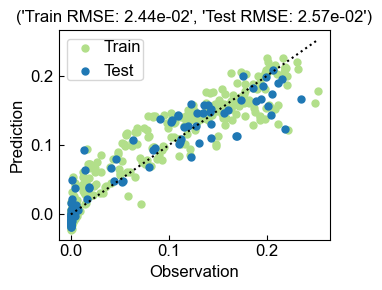

In [4]:
####fit and predict###
ann_regressor.fit(X_train_stand, y_train)
y_train_hat = ann_regressor.predict(X_train_stand)
y_test_hat = ann_regressor.predict(X_test_stand)

# 将数据保存为 CSV 文件
train_df = pd.DataFrame({'y_train': y_train, 'y_train_hat': y_train_hat})
train_df.to_csv('./RMSE/SLME_train.csv', index=False)

test_df = pd.DataFrame({'y_test': y_test, 'y_test_hat': y_test_hat})
test_df.to_csv('./RMSE/SLME_test.csv', index=False)

###plot#####
fontsize = 12
plt.figure(figsize=(3.5,3))
plt.style.use('default')
plt.rc('xtick', labelsize=fontsize)
plt.rc('ytick', labelsize=fontsize)
plt.rcParams['font.family']="Arial"
a = plt.scatter(y_train, y_train_hat, s=25,c='#b2df8a')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k:', lw=1.5)
plt.xlabel('Observation', fontsize=fontsize)
plt.ylabel('Prediction', fontsize=fontsize)
plt.tick_params(direction='in')
plt.title(('Train RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_train, y_train_hat))),\
               'Test RMSE: {:.2e}'.format(np.sqrt(metrics.mean_squared_error(y_test, y_test_hat)))), fontsize=fontsize)
b = plt.scatter(y_test, y_test_hat, s=25,c='#1f78b4')
plt.legend((a,b),('Train','Test'),fontsize=fontsize,handletextpad=0.1,borderpad=0.1)
plt.rcParams['font.family']="Arial"
plt.tight_layout()
plt.show()

In [5]:
import sklearn.metrics as metrics
from scipy.stats.stats import pearsonr

# Defining Metrics
def R2Score(X,Y):
    r2=metrics.r2_score(X,Y)
    return r2
#计算R²分数（R-squared score），也被称为决定系数，它衡量了回归模型对目标变量的方差解释比例。
#参数 X 和 Y 是两个数组，分别表示模型的预测值和实际目标值。

def PearsonCoefficient(X, Y):
    corr, _ = pearsonr(X,Y)
    return corr
#计算Pearson相关系数，衡量了两个变量之间的线性关系强度和方向。

In [6]:
PearsonCoefficient(y_test,y_test_hat)

0.9429823243658499

In [7]:
PearsonCoefficient(y_train,y_train_hat)

0.9487152983471603

In [8]:
R2Score(y_test,y_test_hat)

0.8889428279817884

In [9]:
R2Score(y_train,y_train_hat)

0.8974562828540182

In [10]:
import pandas as pd

# 读取原始 CSV 文件
df_new = pd.read_csv('Bg_data.csv')

# 在这里进行与训练数据相同的预处理
X_new = df_new.iloc[:, 1:58]  # 适当选择特征列
X_new_stand = scaler.transform(X_new)

# 使用模型进行预测
predictions = ann_regressor.predict(X_new_stand)

# 将预测结果添加到原始数据框中
df_new['SLME @ 5um'] = predictions

# 保存更新后的数据框到一个新的 CSV 文件
df_new.to_csv('SLME_data.csv', index=False)

In [11]:
# 计算 Shapley 值
explainer = shap.KernelExplainer(model.predict, X_train_stand)
shap_values = explainer.shap_values(X_test_stand)

Using 390 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
  0%|          | 0/98 [00:00<?, ?it/s]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  1%|          | 1/98 [00:05<09:35,  5.93s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data

 12%|█▏        | 12/98 [01:09<08:19,  5.81s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 13%|█▎        | 13/98 [01:15<08:12,  5.80s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make

 26%|██▌       | 25/98 [02:25<07:10,  5.89s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 27%|██▋       | 26/98 [02:31<07:05,  5.91s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make

 39%|███▉      | 38/98 [03:42<05:55,  5.92s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 40%|███▉      | 39/98 [03:48<05:53,  5.99s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make

 52%|█████▏    | 51/98 [05:00<04:35,  5.87s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 53%|█████▎    | 52/98 [05:05<04:29,  5.85s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make

 65%|██████▌   | 64/98 [06:15<03:19,  5.86s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 66%|██████▋   | 65/98 [06:21<03:12,  5.83s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make

 79%|███████▊  | 77/98 [07:31<02:02,  5.83s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 80%|███████▉  | 78/98 [07:37<01:56,  5.84s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make

 92%|█████████▏| 90/98 [08:46<00:46,  5.78s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
 93%|█████████▎| 91/98 [08:52<00:40,  5.77s/it]The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make

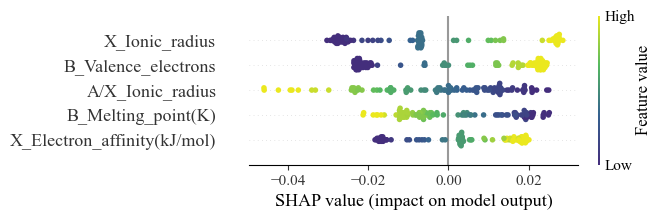

In [12]:
import numpy as np
from matplotlib import cm

# 定义两种颜色
color01 = (68,46,124)
color02 = (53,98,144)
color03 = (85,185,96)
color04 = (235,232,30)

# 将颜色值转换为0-1范围
colors = [tuple([x / 255 for x in color]) for color in [color01, color02, color03, color04]]

# 创建四种颜色之间的渐变
gradient_colors = [colors[0], colors[1], colors[2], colors[3]]


# 生成颜色渐变
n = 256
newcolors = []
for color in gradient_colors:
    rgba_color = cm.colors.to_rgba(color)
    newcolors.append(rgba_color)

newcmp = cm.colors.LinearSegmentedColormap.from_list('BlueYellow', newcolors, N=n)

# 设置全局字体和字号
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 50  # 字号

# 使用修改后的颜色渐变绘制图形
plt.figure()
shap.summary_plot(shap_values, X_test, max_display=5, show=False)
for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if hasattr(fcc, "set_cmap"):
            fcc.set_cmap(newcmp)
# 保存图像
plt.tight_layout()
plt.savefig('./plot/SLME_summary_plot.tif', dpi=300, format='tif', bbox_inches='tight')

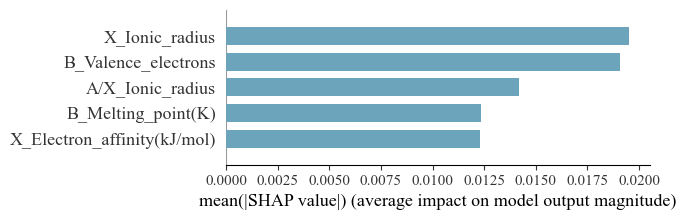

In [13]:
shap.summary_plot(shap_values, X, plot_type="bar", max_display=5, color='#6CA4BC', show=False)
# 保存图像
plt.tight_layout()
plt.savefig('./plot/SLME_summarybar_plot.tif', dpi=300, format='tif', bbox_inches='tight')

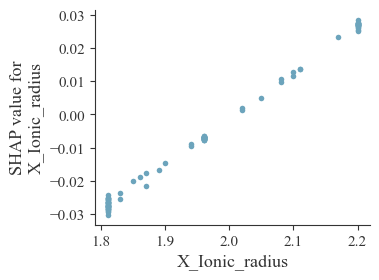

In [14]:
# 设置全局字体和字号
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 80  # 字号
shap.dependence_plot('X_Ionic_radius', shap_values, X_test, interaction_index=None, color='#6CA4BC', show=False)
# 保存图像
plt.tight_layout()
plt.savefig('./plot/SLME_dependence_plot_1.tif', dpi=300, format='tif', bbox_inches='tight')

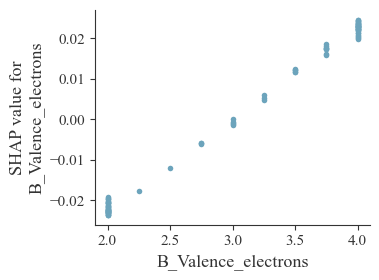

In [15]:
shap.dependence_plot('B_Valence_electrons', shap_values, X_test, interaction_index=None, color='#6CA4BC', show=False)
plt.tight_layout()
plt.savefig('./plot/SLME_dependence_plot_2.tif', dpi=300, format='tif', bbox_inches='tight')

In [16]:
# 设置全局字体和字号
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 50  # 字号
shap.plots.waterfall(shap.Explanation(values=shap_values[0], base_values=explainer.expected_value, data=X_test.iloc[0,:]), max_display=6, show=False)
# 保存图像
plt.tight_layout()
plt.savefig('./plot/SLME_waterfall_plot.pdf', dpi=300, format='pdf', bbox_inches='tight')